# Random Structured CDI Inference with gPIE

This notebook demonstrates Expectation Propagation (EP) inference for the  
**Structured Random Matrix Phase Retrieval** problem using the gPIE framework.

The forward model consists of multiple layers of random phase modulation  
followed by a 2D FFT and amplitude-only measurement.

This model was introduced by:

> Zhiyuan Hu, Julián Tachella, Michael Unser, and Jonathan Dong.  
> **Structured Random Model for Fast and Robust Phase Retrieval**.  
> In *ICASSP 2025 - IEEE International Conference on Acoustics, Speech and Signal Processing*, pp. 1–5. IEEE, 2025.


The method reconstructs a complex-valued object $ \mathbf{x} $ from noisy intensity-only observations of the form:

$$
\mathbf{y} = \left| \mathcal{F} (\mathbf{m}_L \odot \cdots \odot (\mathcal{F} (\mathbf{m}_1 \odot \mathbf{x})) \cdots ) \right| + \varepsilon
$$

where each $ \mathbf{m}_i $ is a random phase mask and $ \mathcal{F} $ denotes the centered 2D FFT.



### 1. Imports and Setup

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from gpie import Graph, SupportPrior, fft2, AmplitudeMeasurement, pmse
from gpie.core.linalg_utils import circular_aperture, random_phase_mask
from gpie.examples.io_utils import load_sample_image

### 2. Problem Description

We consider a cascaded optical system where a complex sample is modulated by  
several layers of random phase masks, followed by a 2D FFT and amplitude measurement:

$$
\mathbf{y} = \left| \mathcal{F} \circ M_L \circ \cdots \circ \mathcal{F} \circ M_1 (\mathbf{x}) \right| + \varepsilon
$$

Where:

- $ \mathbf{x} $: complex-valued object wave
- $ M_i $: diagonal random phase modulation
- $ \mathcal{F} $: 2D centered FFT
- $ \varepsilon \sim \mathcal{N}(0, \sigma^2) $: Gaussian noise

The object is constrained to a known spatial support $ \Omega \subset \mathbb{R}^2 $, enforced via:

$$
\text{supp}(\mathbf{x}) \subseteq \Omega
$$

We use EP inference to estimate $ \mathbf{x} $ from the observed intensity $ \mathbf{y} $.

### 3. Define Graph Class

In [9]:
class StructuredRandomCDI(Graph):
    """
    Factor graph for Structured Random Matrix CDI with multiple FFT layers.
    """
    def __init__(self, support, n_layers, phase_masks, var):
        super().__init__()
        x = ~SupportPrior(support=support, label="sample", dtype=np.complex64)
        for i in range(n_layers):
            x = fft2(phase_masks[i] * x)
        with self.observe():
            AmplitudeMeasurement(var=var, damping=0.3) @ x
        self.compile()

### 4. Build Graph and Inject Sample

In [10]:
# Parameters
H, W = 256, 256
support_radius = 0.3
n_layers = 3
noise_var = 1e-4
rng = np.random.default_rng(seed=42)

# Generate support mask
support = circular_aperture((H, W), radius=support_radius)

# Load images and construct complex sample
amp = load_sample_image("camera", shape=(H, W))
phase = load_sample_image("moon", shape=(H, W))
true_obj = amp * np.exp(1j * 2 * np.pi * phase)
true_obj *= support

# Generate random phase masks
phase_masks = [random_phase_mask((H, W), rng=rng, dtype=np.complex64) for _ in range(n_layers)]

# Build graph and inject object
graph = StructuredRandomCDI(support=support, n_layers=n_layers, phase_masks=phase_masks, var=noise_var)
graph.set_init_rng(np.random.default_rng(seed=1))
graph.get_wave("sample").set_sample(true_obj)
graph.generate_sample(rng=np.random.default_rng(seed=999), update_observed=True)

- A single latent variable $ \mathbf{x} $ is created using `SupportPrior`, enforcing known support
- Each layer applies a random phase mask followed by FFT:
  
  $$
  \mathbf{x} \rightarrow M_1 \rightarrow \mathcal{F} \rightarrow M_2 \rightarrow \mathcal{F} \rightarrow \cdots \rightarrow \mathcal{F} \rightarrow |\cdot| + \varepsilon
  $$

- `set_sample(...)` injects the known ground truth
- `generate_sample(...)` creates noisy amplitude observations, stored in the graph

### 5. Run Inference

In [11]:
n_iter = 200
pse_list = []

def monitor(graph, t):
    if t % 20 == 0 or t == n_iter - 1:
        est = graph.get_wave("sample").compute_belief().data
        err = pmse(est, true_obj)
        pse_list.append(err)
        print(f"[t={t}] PMSE = {err:.5e}")

graph.run(n_iter=n_iter, callback=monitor)

[t=0] PMSE = 1.35539e-01
[t=20] PMSE = 9.48425e-02
[t=40] PMSE = 9.45151e-02
[t=60] PMSE = 8.90578e-02
[t=80] PMSE = 5.81838e-02
[t=100] PMSE = 2.92094e-03
[t=120] PMSE = 7.01933e-04
[t=140] PMSE = 2.31804e-04
[t=160] PMSE = 1.90864e-04
[t=180] PMSE = 1.88427e-04
[t=199] PMSE = 1.88412e-04


### 7. Visualize Reconstruction

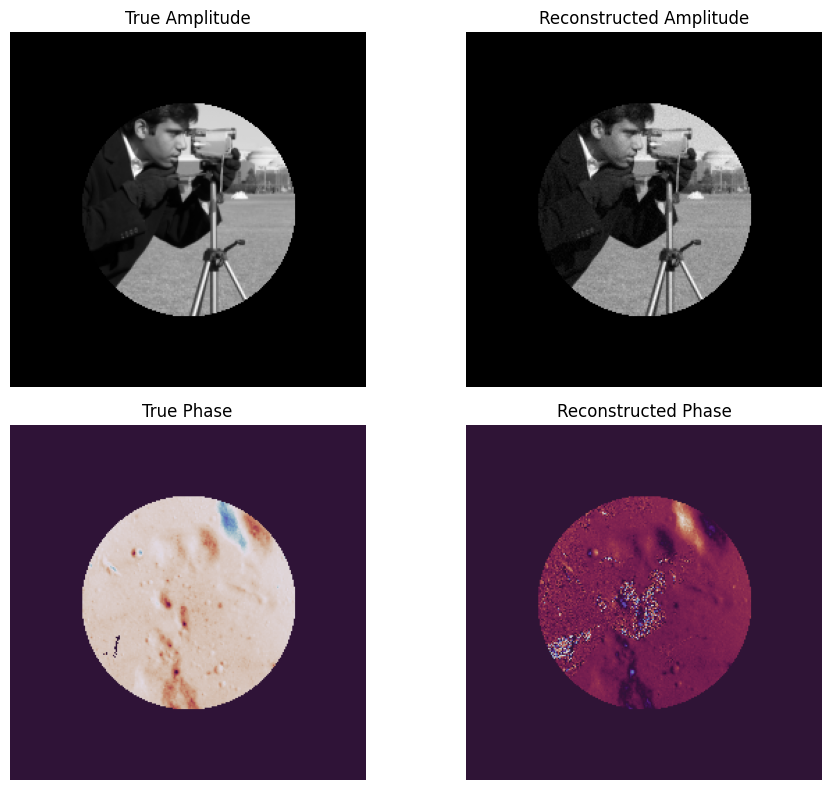

In [12]:
est = graph.get_wave("sample").compute_belief().data

true_amp = np.abs(true_obj)
true_phase = np.angle(true_obj) * (true_amp > 1e-5)
est_amp = np.abs(est)
est_phase = np.angle(est) * (true_amp > 1e-5)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes[0,0].imshow(true_amp, cmap='gray')
axes[0,0].set_title("True Amplitude")

axes[0,1].imshow(est_amp, cmap='gray')
axes[0,1].set_title("Reconstructed Amplitude")

axes[1,0].imshow(true_phase, cmap='twilight')
axes[1,0].set_title("True Phase")

axes[1,1].imshow(est_phase, cmap='twilight')
axes[1,1].set_title("Reconstructed Phase")

for ax in axes.flat:
    ax.axis("off")
plt.tight_layout()
plt.show()
